## Filtrado de señales utilizando filtros IIR

#### Importación de librerias

In [30]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import re
from scipy import signal

#### Abrir archivo txt

In [31]:
f = open("signals/ECG_reposo_sujeto2.txt")
raw_data = f.readlines()[1] # con f.read() leemos todo el contenido
f.close()

raw_data

'# {"98:D3:71:FD:62:1E": {"position": 0, "device": "bitalino_rev", "device name": "98:D3:71:FD:62:1E", "device connection": "BTH98:D3:71:FD:62:1E", "sampling rate": 1000, "resolution": [4, 1, 1, 1, 1, 10], "firmware version": 1282, "comments": "", "keywords": "", "mode": 0, "sync interval": 2, "date": "2023-9-15", "time": "10:30:59.552", "channels": [2], "sensor": ["ECGBIT"], "label": ["A2"], "column": ["nSeq", "I1", "I2", "O1", "O2", "A2"], "special": [{}], "digital IO": [0, 0, 1, 1]}}\n'

In [32]:
x = re.findall("[0-5][0-9][0-9]\d", raw_data)

print(x)

['1000', '1282', '2023']


In [33]:
Fs = float(x[0])
Ts=1/Fs

print(f" Fs={Fs} hz\n Ts={Ts} s")

 Fs=1000.0 hz
 Ts=0.001 s


#### Lectura de archivos excluyendo encabezados

In [34]:
SenalECG = np.genfromtxt("Signals/ECG_reposo_sujeto2.txt", delimiter="\t",skip_header = 3)


#### Visualización de la señal cruda

Text(0.5, 0, 'Tiempo (s)')

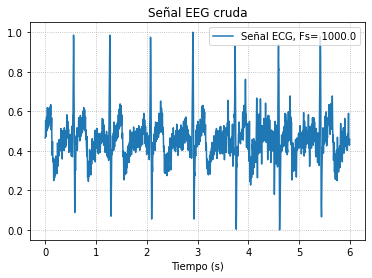

In [35]:
# Conversión de las señales en arrays
ECG = SenalECG[:,5]
ECG = ECG [:6000]

#Normalización
y1 = ECG  - np.min(ECG)
y1 = y1 / np.max(y1)
t1 = (np.arange(0,len(y1)) / Fs)

plt.plot(t1, y1, label=f"Señal ECG, Fs= {Fs}")
plt.legend(loc="upper right")
plt.title("Señal EEG cruda")    # graficamos la señal
plt.grid(linestyle=":")
plt.xlabel("Tiempo (s)")



#### Dominio de la frecuencia de la señal cruda

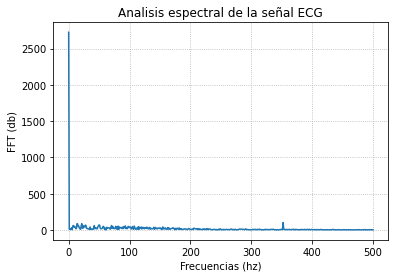

In [50]:
N = 2 ** 10 # Resolución del bitalino
X = np.fft.fft(y1)
X = X[0:N//2]
X = np.abs(X)
F = np.linspace(0,Fs/2,N//2)

plt.plot(F, X)
plt.grid(linestyle=":")
plt.title("Analisis espectral de la señal ECG")
plt.xlabel("Frecuencias (hz)")
plt.ylabel("FFT (db)")

# peaks, _= signal.find_peaks(X, height=100)
# plt.plot(peaks, X[peaks], 'x')
plt.show()

#### Aplicación de filtros

##### Filtro IIR

In [40]:
Wp = 0.5/ (Fs/2)
Ws = 50/(Fs/2)

N_ord, Wc= signal.buttord(Wp, Ws, gpass=3, gstop=40, analog=True) #gpass=loss in passband edge frecuencies, gstop= attenuation in stopband edge frecuencies 

print(f"Orden del filtro: {N_ord}")


Orden del filtro: 2


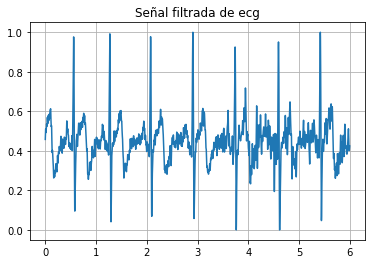

In [41]:
b, a = signal.butter(2,[Wp,Ws],'bandpass')
ecg_filtered= signal.filtfilt(b, a, y1)
ecg_filtered = ecg_filtered  - np.min(ecg_filtered)
ecg_filtered = ecg_filtered / np.max(ecg_filtered)
plt.title('Señal filtrada de ecg con IIR')
plt.plot(t1,ecg_filtered, label=f"bandpass {Wp, Ws}")
plt.grid()


##### Aplicacion de filtro FIR

In [51]:
from scipy.signal import firwin, lfilter


M = 56 # Orden del fitro
wp = 0.5 #Frecuencia baja
ws = 50 # Frecuencia alta

#Diseño del filtro
w = firwin(numtaps=M, cutoff=[wp,ws], window='kaiser', fs=Fs)
w = np.round(w,3)

#Aplicación del filtro
ecg_filtered_fir = lfilter(w,1,y1)

plt.title('Señal filtrada de ecg con FIR')
plt.plot(t1,ecg_filtered_fir, label=f"bandpass {Wp, Ws}")
plt.grid()





ValueError: A filter with an even number of coefficients must have zero response at the Nyquist frequency.